<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">
 
# Ensembles: Bagging and Boosting
 
_Author: Joseph Nelson (DC)_

*Adapted from Chapter 8 of [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/)*

---

## Learning Objectives

Students will be able to:

- Understand how and why decision trees can be improved using bagging and random forests.
- Build random forest models for classification and regression.
- Know how to extract the most important predictors in a random forest model.


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

<a id="introduction"></a>
# Introduction

### What is Ensembling?

**Ensemble learning (or "ensembling")** is the process of combining several predictive models in order to produce a combined model that is more accurate than any individual model. For example, given predictions from several models we could:

- **Regression:** Take the average of the predictions.
- **Classification:** Take a vote and use the most common prediction.

For ensembling to work well, the models must be:

- **Accurate:** They outperform the null model.
- **Independent:** Their predictions are generated using different processes.

**The big idea:** If you have a collection of individually imperfect (and independent) models, the "one-off" mistakes made by each model are probably not going to be made by the rest of the models, and thus the mistakes will be discarded when you average the models.

There are two basic **methods for ensembling:**

- Manually ensembling your individual models.
- Using a model that ensembles for you.

<a id="part-one"></a>
# Part 1: Manual Ensembling

What makes an effective manual ensemble?

- Different types of **models**.
- Different combinations of **features**.
- Different **tuning parameters**.

![Machine learning flowchart](assets/crowdflower_ensembling.jpg)

*Machine learning flowchart created by the [winner](https://github.com/ChenglongChen/Kaggle_CrowdFlower) of Kaggle's [CrowdFlower competition](https://www.kaggle.com/c/crowdflower-search-relevance)*.

### Comparing Manual Ensembling With a Single Model Approach

**Advantages of manual ensembling:**

- It increases predictive accuracy.
- It's easy to get started.

**Disadvantages of manual ensembling:**

- It decreases interpretability.
- It takes longer to train.
- It takes longer to predict.
- It is more complex to automate and maintain.
- Small gains in accuracy may not be worth the added complexity.

<a id="part-two"></a>
# Part 2: Bagging

The primary weakness of **decision trees** is that they don't tend to have the best predictive accuracy. This is partially because of **high variance**, meaning that different splits in the training data can lead to very different trees.

**Bagging** is a general-purpose procedure for reducing the variance of a machine learning method but is particularly useful for decision trees. Bagging is short for **bootstrap aggregation**, meaning the aggregation of bootstrap samples.

A **bootstrap sample is a random sample with replacement**. So, it has the same size as the original sample but might duplicate some of the original observations.

In [11]:
# Set a seed for reproducibility.
np.random.seed(4)

# Create an array of 1 through 20.
nums = np.arange(1, 21)
print(nums)

# Sample that array 20 times with replacement.
print(np.random.choice(a=nums, size=20, replace=True))

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
[15  6  2  9  9 19 10  8 14  9  5 19 13  7 11  4  1 10  7  7]


**How does bagging work (for decision trees)?**

1. Grow B trees using B bootstrap samples from the training data.
2. Train each tree on its bootstrap sample and make predictions.
3. Combine the predictions:
    - Average the predictions for **regression trees**.
    - Take a vote for **classification trees**.

Notes:

- **Each bootstrap sample** should be the same size as the original training set. (It may contain repeated rows.)
- **B** should be a large enough value that the error seems to have "stabilized".
- The trees are **grown deep** so that they have low bias/high variance.

Bagging increases predictive accuracy by **reducing the variance**, **similar to how cross-validation reduces the variance associated with train/test split** (for estimating out-of-sample error) by splitting many times an averaging the results.

<a id="manual-bagged"></a>
## Manually Implementing Bagged Decision Trees (with B=10)

In [12]:
# Read in and prepare the vehicle training data.
import pandas as pd

path = './data/vehicles_train.csv'
train = pd.read_csv(path)
train['vtype'] = train.vtype.map({'car':0, 'truck':1})
train

,price,year,miles,doors,vtype
0,22000,2012,13000,2,0
1,14000,2010,30000,2,0
2,13000,2010,73500,4,0
3,9500,2009,78000,4,0
4,9000,2007,47000,4,0
5,4000,2006,124000,2,0
6,3000,2004,177000,4,0
7,2000,2004,209000,4,1
8,3000,2003,138000,2,0
9,1900,2003,160000,4,0


In [13]:
# Set a seed for reproducibility.
np.random.seed(123)

# Create ten bootstrap samples (which will be used to select rows from the DataFrame).
samples = [np.random.choice(a=14, size=14, replace=True) for _ in range(1, 11)]
samples

[array([13,  2, 12,  2,  6,  1,  3, 10, 11,  9,  6,  1,  0,  1]),
 array([ 9,  0,  0,  9,  3, 13,  4,  0,  0,  4,  1,  7,  3,  2]),
 array([ 4,  7,  2,  4,  8, 13,  0,  7,  9,  3, 12, 12,  4,  6]),
 array([ 1,  5,  6, 11,  2,  1, 12,  8,  3, 10,  5,  0, 11,  2]),
 array([10, 10,  6, 13,  2,  4, 11, 11, 13, 12,  4,  6, 13,  3]),
 array([10,  0,  6,  4,  7, 11,  6,  7,  1, 11, 10,  5,  7,  9]),
 array([ 2,  4,  8,  1, 12,  2,  1,  1,  3, 12,  5,  9,  0,  8]),
 array([11,  1,  6,  3,  3, 11,  5,  9,  7,  9,  2,  3, 11,  3]),
 array([ 3,  8,  6,  9,  7,  6,  3,  9,  6, 12,  6, 11,  6,  1]),
 array([13, 10,  3,  4,  3,  1, 13,  0,  5,  8, 13,  6, 11,  8])]

In [14]:
# Show the rows for the first decision tree.
train.iloc[samples[0], :]

,price,year,miles,doors,vtype
13,1300,1997,138000,4,0
2,13000,2010,73500,4,0
12,1800,1999,163000,2,1
2,13000,2010,73500,4,0
6,3000,2004,177000,4,0
1,14000,2010,30000,2,0
3,9500,2009,78000,4,0
10,2500,2003,190000,2,1
11,5000,2001,62000,4,0
9,1900,2003,160000,4,0


In [15]:
# Read in and prepare the vehicle testing data.
path = './data/vehicles_test.csv'
test = pd.read_csv(path)
test['vtype'] = test.vtype.map({'car':0, 'truck':1})
test

,price,year,miles,doors,vtype
0,3000,2003,130000,4,1
1,6000,2005,82500,4,0
2,12000,2010,60000,2,0


In [16]:
from sklearn.tree import DecisionTreeRegressor

# Grow each tree deep.
treereg = DecisionTreeRegressor(max_depth=None, random_state=123)

# List for storing predicted price from each tree:
predictions = []

# Define testing data.
X_test = test.iloc[:, 1:]
y_test = test.iloc[:, 0]

# Grow one tree for each bootstrap sample and make predictions on testing data.
for sample in samples:
    X_train = train.iloc[sample, 1:]
    y_train = train.iloc[sample, 0]
    treereg.fit(X_train, y_train)
    y_pred = treereg.predict(X_test)
    predictions.append(y_pred)

# Convert predictions from list to NumPy array.
predictions = np.array(predictions)
predictions

array([[ 1300.,  5000., 14000.],
       [ 1300.,  1300., 13000.],
       [ 3000.,  3000., 13000.],
       [ 4000.,  5000., 13000.],
       [ 1300.,  5000., 13000.],
       [ 4000.,  5000., 14000.],
       [ 4000.,  4000., 13000.],
       [ 4000.,  5000., 13000.],
       [ 3000.,  5000.,  9500.],
       [ 4000.,  5000.,  9000.]])

In [17]:
# Average predictions.
np.mean(predictions, axis=0)

array([ 2990.,  4330., 12450.])

In [18]:
# Calculate RMSE.
from sklearn import metrics
y_pred = np.mean(predictions, axis=0)
np.sqrt(metrics.mean_squared_error(y_test, y_pred))

998.5823284370031

<a id="manual-sklearn"></a>
## Bagged Decision Trees in `scikit-learn` (with B=500)

In [19]:
# Define the training and testing sets.
X_train = train.iloc[:, 1:]
y_train = train.iloc[:, 0]
X_test = test.iloc[:, 1:]
y_test = test.iloc[:, 0]

In [20]:
# Instruct BaggingRegressor to use DecisionTreeRegressor as the "base estimator."
from sklearn.ensemble import BaggingRegressor
bagreg = BaggingRegressor(DecisionTreeRegressor(), n_estimators=500, bootstrap=True, oob_score=True, random_state=1)

In [21]:
# Fit and predict.
bagreg.fit(X_train, y_train)
y_pred = bagreg.predict(X_test)
y_pred

array([ 3335. ,  5419.8, 12956. ])

In [22]:
bagreg.oob_score_

0.7662607997982768

In [23]:
# Calculate RMSE.
np.sqrt(metrics.mean_squared_error(y_test, y_pred))

673.9913550385247

<a id="oos-error"></a>
## Estimating Out-of-Sample Error

For bagged models, out-of-sample error can be estimated without using **train/test split** or **cross-validation**!

For each tree, the **unused observations** are called "out-of-bag" observations.

In [24]:
# Show the first bootstrap sample.
samples[0]

array([13,  2, 12,  2,  6,  1,  3, 10, 11,  9,  6,  1,  0,  1])

In [25]:
# Show the "in-bag" observations for each sample.
for sample in samples:
    print(set(sample))

{0, 1, 2, 3, 6, 9, 10, 11, 12, 13}
{0, 1, 2, 3, 4, 7, 9, 13}
{0, 2, 3, 4, 6, 7, 8, 9, 12, 13}
{0, 1, 2, 3, 5, 6, 8, 10, 11, 12}
{2, 3, 4, 6, 10, 11, 12, 13}
{0, 1, 4, 5, 6, 7, 9, 10, 11}
{0, 1, 2, 3, 4, 5, 8, 9, 12}
{1, 2, 3, 5, 6, 7, 9, 11}
{1, 3, 6, 7, 8, 9, 11, 12}
{0, 1, 3, 4, 5, 6, 8, 10, 11, 13}


In [26]:
# Show the "out-of-bag" observations for each sample.
for sample in samples:
    print(sorted(set(range(14)) - set(sample)))

[4, 5, 7, 8]
[5, 6, 8, 10, 11, 12]
[1, 5, 10, 11]
[4, 7, 9, 13]
[0, 1, 5, 7, 8, 9]
[2, 3, 8, 12, 13]
[6, 7, 10, 11, 13]
[0, 4, 8, 10, 12, 13]
[0, 2, 4, 5, 10, 13]
[2, 7, 9, 12]


**Calculating "out-of-bag error:"**

1. For each observation in the training data, predict its response value using **only** the trees in which that observation was out-of-bag. Average those predictions (for regression) or take a vote (for classification).
2. Compare all predictions to the actual response values in order to compute the out-of-bag error.

When B is sufficiently large, the **out-of-bag error** is an accurate estimate of **out-of-sample error**.

In [27]:
# Compute the out-of-bag R-squared score (not MSE, unfortunately) for B=500.
bagreg.oob_score_

0.7662607997982768

### Estimating Feature Importance

Bagging increases **predictive accuracy** but decreases **model interpretability** because it's no longer possible to visualize the tree to understand the importance of each feature.

However, we can still obtain an overall summary of **feature importance** from bagged models:

- **Bagged regression trees:** Calculate the total amount that **MSE** decreases due to splits over a given feature, averaged over all trees
- **Bagged classification trees:** Calculate the total amount that **Gini index** decreases due to splits over a given feature, averaged over all trees

<a id="part-three"></a>
## Random Forests

Random Forests offer a **slight variation on bagged trees** with even better performance:

- Exactly like bagging, we create an ensemble of decision trees using bootstrapped samples of the training set.
- However, when building each tree, each time a split is considered, a **random sample of m features** is chosen as split candidates from the **full set of p features**. The split is only allowed to use **one of those m features**.
    - A new random sample of features is chosen for **every single tree at every single split**.
    - For **classification**, m is typically chosen to be the **square root of p**.
    - For **regression**, m is typically chosen to be somewhere **between p/3 and p**.

What's the point?

- Suppose there is **one very strong feature** in the data set. When using bagged trees, most of the trees will use that feature as the top split, resulting in an ensemble of similar trees that are **highly correlated**.
- Averaging highly correlated quantities does not significantly reduce variance (which is the entire goal of bagging).
- **By randomly leaving out candidate features from each split, random forests "decorrelate" the trees to the extent that the averaging process can reduce the variance of the resulting model**.
- Another way of looking at it is that sometimes one or two strong features dominate every tree in bagging, resulting in essentially the same tree as every predictor. (This is what was meant when saying the trees could be highly correlated.) By using a subset of features to generate each tree, we get a wider variety of predictive trees that do not all use the same dominant features.

<a id="part-one"></a>

# Part 3: Boosting
Boosted decision trees are built sequentially. After the first tree gets built, the algorithm analysis its performance. The next tree that gets built puts heavier weights on misclassified observations (in particular False Negatives), and so on. This make Boosting the ideal algorithm to use when there is a large class imbalance (e.g. Fraud detection). 

The 3 most popular Boosting algorithms (and the original papers describing them) are listed below:
- XGBoost: https://xgboost.readthedocs.io/en/latest/ (https://arxiv.org/pdf/1603.02754.pdf)
- (Microsoft's) LightGBM: https://lightgbm.readthedocs.io/en/latest/ (https://papers.nips.cc/paper/6907-lightgbm-a-highly-efficient-gradient-boosting-decision-tree.pdf)
- (Yandex's) CatBoost: https://catboost.ai/ (https://arxiv.org/pdf/1706.09516.pdf)

Not only are modern Boosting algorithms much quicker at building boosting trees than sklearn's `GradientBoostingClassifier`, but `LightGBM` and `CatBoost` also have inbuilt ways of dealing with categorical features so no `LabelEncoding` or `OneHotEncoding` has to be applied.

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score

# Read in the data.
path = './data/titanic.csv'
titanic = pd.read_csv(path)

# Encode female as 0 and male as 1.
titanic['Sex'] = titanic.Sex.map({'female':0, 'male':1})

# Fill in the missing values for age with the median age.
titanic.Age.fillna(titanic.Age.median(), inplace=True)

# Create a DataFrame of dummy variables for Embarked.
embarked_dummies = pd.get_dummies(titanic.Embarked, prefix='Embarked')
embarked_dummies.drop(embarked_dummies.columns[0], axis=1, inplace=True)

# Concatenate the original DataFrame and the dummy DataFrame.
titanic = pd.concat([titanic, embarked_dummies], axis=1)

# Print the updated DataFrame.
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,S,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,C,0,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,S,0,1
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,S,0,1


### `sklearn.GradientBoostingClassifier`

In [29]:
# selecting features by type 
titanic.select_dtypes(exclude=["object", "category"]).columns

Index(['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
       'Fare', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [30]:
from sklearn.ensemble import GradientBoostingClassifier
# Define X and y.
feature_cols = ['Pclass', 'Sex', 'Age', 'Embarked_Q', 'Embarked_S']

X = titanic[feature_cols]
y = titanic.Survived

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
y_pred = gbc.predict(X_test)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred),
      "\nAccuracy:", round(accuracy_score(y_test, y_pred) * 100, 2), "%",
      "\nPrecision:", round(precision_score(y_test, y_pred) * 100, 2), "%",
      "\nRecall:", round(recall_score(y_test, y_pred) * 100, 2), "%",      
      "\nF1:", round(f1_score(y_test, y_pred) * 100, 2), "%")

Confusion Matrix:
 [[163  19]
 [ 39  74]] 
Accuracy: 80.34 % 
Precision: 79.57 % 
Recall: 65.49 % 
F1: 71.84 %


## Newer Boosting Algorighms (Classification Examples)
- Have inbuild ways of dealing with categorical features
- Are optimised (in the form of a few very clever tricks - read the papers for more details) to train very quickly
- Have inbuild logic to use training and validation sets for model builds.

In [32]:
titanic = titanic.dropna()

feature_cols = ["Pclass", "Sex", "Age", "Embarked"]

titanic["Embarked"] = titanic["Embarked"].astype('category')

X = titanic[feature_cols]
y = titanic.Survived

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)


X_train, X_validation, y_train, y_validation = train_test_split(
    X_train, y_train, test_size=0.33, random_state=42, stratify=y_train
)

cat = ["Embarked"]

### LightGBM

In [33]:
import lightgbm as lgbm

# dataset for lightgbm
train_set = lgbm.Dataset(data=X_train, 
                         label=y_train,
                         categorical_feature=cat, 
                         free_raw_data=False)

validation_set = lgbm.Dataset(data=X_validation, 
                         label=y_validation,
                         categorical_feature=cat, 
                         free_raw_data=False)

test_set = lgbm.Dataset(data=X_test, 
                         label=y_test,
                         categorical_feature=cat, 
                         free_raw_data=False) 

In [37]:
y_train.value_counts()[1]

60

In [38]:
# model parameters defined
lgbm_params = {'max_depth': 3, 
               'learning_rate': 0.01, 
               'objective': 'binary', 
               'scale_pos_weight': y_train.value_counts()[0] / y_train.value_counts()[1] ,                    
               'boost_from_average': False,
               'feature_fraction' : 0.7,
          }

evaluation_results = {}

In [39]:
model = lgbm.train(train_set = train_set, 
                   params = lgbm_params,
                   num_boost_round = 1000,
                   valid_sets = [train_set, validation_set],
                   valid_names = ['Train', 'Validate'], 
                   evals_result = evaluation_results,
                   verbose_eval = 1,
                   early_stopping_rounds=50,
                   )

y_pred_proba = model.predict(X_test)
y_pred = np.where(y_pred_proba > 0.5, 1, 0)
# saving model
# dump(model, 'model_lgbm.joblib')  
# dump(evaluation_results, 'evaluation_results_lgbm.joblib')

//anaconda/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	Train's binary_logloss: 0.688764	Validate's binary_logloss: 0.689229
Training until validation scores don't improve for 50 rounds
[2]	Train's binary_logloss: 0.684318	Validate's binary_logloss: 0.685258
[3]	Train's binary_logloss: 0.679965	Validate's binary_logloss: 0.68138
[4]	Train's binary_logloss: 0.675853	Validate's binary_logloss: 0.677727
[5]	Train's binary_logloss: 0.671827	Validate's binary_logloss: 0.674158
[6]	Train's binary_logloss: 0.670324	Validate's binary_logloss: 0.673659
[7]	Train's binary_logloss: 0.666395	Validate's binary_logloss: 0.670185
[8]	Train's binary_logloss: 0.662396	Validate's binary_logloss: 0.666658
[9]	Train's binary_logloss: 0.658479	Validate's binary_logloss: 0.663212
[10]	Train's binary_logloss: 0.657047	Validate's binary_logloss: 0.662766
[11]	Train's binary_logloss: 0.655645	Validate's binary_logloss: 0.66234
[12]	Train's binary_logloss: 0.654271	Validate's binary_logloss: 0.661934
[13]	Train's binary_logloss: 0.652925	Validate's binary_loglos

In [40]:
evaluation_results

{'Train': OrderedDict([('binary_logloss',
               [0.6887644726538904,
                0.6843179503845387,
                0.6799645442839799,
                0.6758529669298365,
                0.6718270316298764,
                0.6703235861706898,
                0.6663952034043186,
                0.6623962983955093,
                0.6584785659329445,
                0.6570470019214102,
                0.6556447416311195,
                0.6542710993037424,
                0.6529254092477514,
                0.6492831860168061,
                0.6479766619700734,
                0.6444194613264164,
                0.6407888875529363,
                0.6373724965850822,
                0.633881495931415,
                0.6305990610507747,
                0.629373484935246,
                0.6281724304510098,
                0.6269953486462173,
                0.623807324702521,
                0.6205420852252272,
                0.6194074656565591,
                0.6163516

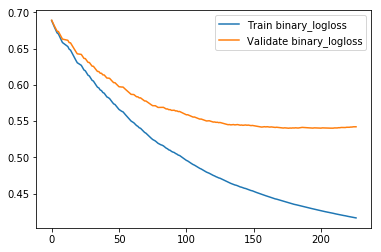

In [41]:
plt.plot([index for index in range(len(evaluation_results["Train"]["binary_logloss"]))],
         evaluation_results["Train"]["binary_logloss"], label="Train binary_logloss")
plt.plot([index for index in range(len(evaluation_results["Validate"]["binary_logloss"]))],
         evaluation_results["Validate"]["binary_logloss"], label="Validate binary_logloss")
plt.legend();

In [42]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred),
      "\nAccuracy:", round(accuracy_score(y_test, y_pred) * 100, 2), "%",
      "\nPrecision:", round(precision_score(y_test, y_pred) * 100, 2), "%",
      "\nRecall:", round(recall_score(y_test, y_pred) * 100, 2), "%",      
      "\nF1:", round(f1_score(y_test, y_pred) * 100, 2), "%")

Confusion Matrix:
 [[17  6]
 [14 30]] 
Accuracy: 70.15 % 
Precision: 83.33 % 
Recall: 68.18 % 
F1: 75.0 %


### CatBoost

In [43]:
from catboost import CatBoostClassifier, Pool
SEED=42
#model parameters defined
model = CatBoostClassifier(iterations=500,
                          depth=4,
                          loss_function='Logloss',
                          custom_metric=['Recall','F1','Precision'],
                          eval_metric='F1', 
                          cat_features=cat,
                          scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1] ,
                          thread_count=-1,
                          early_stopping_rounds=50,
                          verbose=True,
                          random_seed=SEED,
                          has_time=False
                          )

In [44]:
# fitting model
model.fit(Pool(data=X_train, 
               label=y_train, 
              cat_features=cat,
              #weight=X_train.COL_YOU_WANT_TO_WEIGHT
              ),
          eval_set = (X_validation, y_validation),
          logging_level='Verbose'
         )

y_pred = model.predict(X_test)

# saving model
# dump(model, 'catboost_model.joblib')  
# dump(model.evals_result_, 'evaluation_results_catboost.joblib')

Learning rate set to 0.023635
0:	learn: 0.7843137	test: 0.7407407	best: 0.7407407 (0)	total: 143ms	remaining: 1m 11s
1:	learn: 0.7843137	test: 0.7407407	best: 0.7407407 (0)	total: 146ms	remaining: 36.3s
2:	learn: 0.7843137	test: 0.7407407	best: 0.7407407 (0)	total: 148ms	remaining: 24.5s
3:	learn: 0.7843137	test: 0.7407407	best: 0.7407407 (0)	total: 151ms	remaining: 18.7s
4:	learn: 0.7843137	test: 0.7407407	best: 0.7407407 (0)	total: 162ms	remaining: 16s
5:	learn: 0.7843137	test: 0.7407407	best: 0.7407407 (0)	total: 164ms	remaining: 13.5s
6:	learn: 0.7843137	test: 0.7407407	best: 0.7407407 (0)	total: 187ms	remaining: 13.2s
7:	learn: 0.7843137	test: 0.7407407	best: 0.7407407 (0)	total: 200ms	remaining: 12.3s
8:	learn: 0.8518519	test: 0.7636364	best: 0.7636364 (8)	total: 231ms	remaining: 12.6s
9:	learn: 0.8518519	test: 0.7636364	best: 0.7636364 (8)	total: 255ms	remaining: 12.5s
10:	learn: 0.8518519	test: 0.7636364	best: 0.7636364 (8)	total: 283ms	remaining: 12.6s
11:	learn: 0.8518519	tes

In [45]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred),
      "\nAccuracy:", round(accuracy_score(y_test, y_pred) * 100, 2), "%",
      "\nPrecision:", round(precision_score(y_test, y_pred) * 100, 2), "%",
      "\nRecall:", round(recall_score(y_test, y_pred) * 100, 2), "%",      
      "\nF1:", round(f1_score(y_test, y_pred) * 100, 2), "%")

Confusion Matrix:
 [[20  3]
 [15 29]] 
Accuracy: 73.13 % 
Precision: 90.62 % 
Recall: 65.91 % 
F1: 76.32 %


----

<a id="decision-tree"></a>
## Optional: Predicting Salary With a Decision Tree

Let's first recall how we might predict salary using a single decision tree.

We'll first find the best **max_depth** for a decision tree using cross-validation:

In [ ]:
# Read in the data.
path ='./data/hitters.csv'
hitters = pd.read_csv(path)

# Remove rows with missing values.
hitters.dropna(inplace=True)

# Encode categorical variables as integers.
hitters['League'] = pd.factorize(hitters.League)[0]
hitters['Division'] = pd.factorize(hitters.Division)[0]
hitters['NewLeague'] = pd.factorize(hitters.NewLeague)[0]

# Define features: Exclude career statistics (which start with "C") and the response (salary).
feature_cols = hitters.columns[hitters.columns.str.startswith('C') == False].drop('Salary')
feature_cols

# Define X and y.
X = hitters[feature_cols]
y = hitters.Salary

In [ ]:
# List of values to try for max_depth:
max_depth_range = list(range(1, 21))

# List to store the average RMSE for each value of max_depth:
RMSE_scores = []

# Use 10-fold cross-validation with each value of max_depth.
from sklearn.model_selection import cross_val_score
for depth in max_depth_range:
    treereg = DecisionTreeRegressor(max_depth=depth, random_state=1)
    MSE_scores = cross_val_score(treereg, X, y, cv=10, scoring='neg_mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

In [ ]:
# Plot max_depth (x-axis) versus RMSE (y-axis).
plt.plot(max_depth_range, RMSE_scores);
plt.xlabel('max_depth');
plt.ylabel('RMSE (lower is better)')
plt.xlim([1, 19]);

In [ ]:
# Show the best RMSE and the corresponding max_depth.
sorted(zip(RMSE_scores, max_depth_range))[0]

In [ ]:
# max_depth=2 was best, so fit a tree using that parameter.
treereg = DecisionTreeRegressor(max_depth=2, random_state=1)
treereg.fit(X, y)

In [ ]:
# Compute feature importances.
pd.DataFrame({'feature': feature_cols, 'importance': treereg.feature_importances_}).sort_values(
    by='importance', ascending=False)

<a id="random-forest-demo"></a>
## Optional: Predicting Salary With a Random Forest

### Fitting a Random Forest With the Best Parameters

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
# max_features=5 is best and n_estimators=150 is sufficiently large.
rfreg = RandomForestRegressor(n_estimators=150, max_features=5, oob_score=True, random_state=1)
rfreg.fit(X, y)

In [ ]:
# Compute feature importances.
pd.DataFrame({'feature': feature_cols, 'importance': rfreg.feature_importances_}).sort_values(
    by='importance', ascending=False)

In [ ]:
# Compute the out-of-bag R-squared score.
print((rfreg.oob_score_))

# Find the average RMSE.
scores = cross_val_score(rfreg, X, y, cv=10, scoring='neg_mean_squared_error')
np.mean(np.sqrt(-scores))

#### Reducing X to its Most Important Features

In [ ]:
# Check the shape of X.
X.shape

** It important not to select features before separating your train from your test otherwise you are selecting features based on all known observations and introducing more of the information in the test data to the model when you fit it on the training data. **

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 89)

In [ ]:
# Fit the model on only the train data
rfreg = RandomForestRegressor(n_estimators=150, max_features=5, oob_score=True, random_state=1)
rfreg.fit(X_train, y_train)

In [ ]:
# Set a threshold for which features to include.
from sklearn.feature_selection import SelectFromModel

print(SelectFromModel(rfreg, threshold='mean', prefit=True).transform(X_train).shape)
print(SelectFromModel(rfreg, threshold='median', prefit=True).transform(X_train).shape)

Using the fit model and the features from the train data to transform the test data

In [ ]:
# Create a new feature matrix that only includes important features.

X_important = SelectFromModel(rfreg, threshold='mean', prefit=True).transform(X_test)

In [ ]:
# Check the RMSE for a random forest that only includes important features.
rfreg = RandomForestRegressor(n_estimators=150, max_features=3, random_state=1)

scores = cross_val_score(rfreg, X_important, y_test, cv=10, scoring='neg_mean_squared_error')
np.mean(np.sqrt(-scores))

In this case, the error increased slightly. Often parameter tuning is required to achieve optimal results.

<a id="comparing"></a>
## Comparing Random Forests With Decision Trees

**Advantages of random forests:**

- Their performance is competitive with the best supervised learning methods.
- They provide a more reliable estimate of feature importance.
- They allow you to estimate out-of-sample error without using train/test split or cross-validation.

**Disadvantages of random forests:**

- They are less interpretable.
- They are slower to train.
- They are slower to predict.

<a id="part-four"></a>
## Optional: Building and Tuning Decision Trees and Random Forests

In this section, we will implement random forests in scikit-learn.

- Major League Baseball player data from 1986-87: [data](https://github.com/justmarkham/DAT8/blob/master/data/hitters.csv), [data dictionary](https://cran.r-project.org/web/packages/ISLR/ISLR.pdf) (page 7)
- Each observation represents a player.
- **Goal:** Predict player salary.

### Preparing the Data

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rfreg = RandomForestRegressor()
rfreg

# Read in the data.
path ='./data/hitters.csv'
hitters = pd.read_csv(path)

# Remove rows with missing values.
hitters.dropna(inplace=True)

hitters.head()

In [ ]:
# Encode categorical variables as integers.
hitters['League'] = pd.factorize(hitters.League)[0]
hitters['Division'] = pd.factorize(hitters.Division)[0]
hitters['NewLeague'] = pd.factorize(hitters.NewLeague)[0]
hitters.head()

In [ ]:
# Create a scatter plot of hits vs years, colored by salary
hitters.plot(kind='scatter', x='Years', y='Hits', c='Salary', colormap='jet', xlim=(0, 25), ylim=(0, 250));

In [ ]:
# Define features: Exclude career statistics (which start with "C") and the response (salary).
feature_cols = hitters.columns[hitters.columns.str.startswith('C') == False].drop('Salary')
feature_cols

In [ ]:
# Define X and y.
X = hitters[feature_cols]
y = hitters.Salary

### Tuning n_estimators

One important tuning parameter is **n_estimators**, which represents the number of trees that should be grown. This should be a large enough value that the error seems to have "stabilized."

In [ ]:
# List of values to try for n_estimators:
estimator_range = list(range(10, 310, 10))

# List to store the average RMSE for each value of n_estimators:
RMSE_scores = []

# Use five-fold cross-validation with each value of n_estimators (Warning: Slow!).
for estimator in estimator_range:
    rfreg = RandomForestRegressor(n_estimators=estimator, random_state=1)
    MSE_scores = cross_val_score(rfreg, X, y, cv=5, scoring='neg_mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

In [ ]:
# Plot RMSE (y-axis) versus n_estimators (x-axis).

plt.plot(estimator_range, RMSE_scores);

plt.xlabel('n_estimators');
plt.ylabel('RMSE (lower is better)');

** In theory, the RMSE will continue to decrease and eventually level out.  Adding more estimators will neither (noticably) increase or decrease the RMSE (or other loss metric). However, introduction of noise can lead to random spikes as the n_estimators changes. This example is particularly interesting as after about 120 estimators the RMSE seems to steadily rise as more estimators are added.**

### Tuning max_features

The other important tuning parameter is **max_features**, which represents the number of features that should be considered at each split.

In [ ]:
# List of values to try for max_features:
feature_range = list(range(1, len(feature_cols)+1))

# List to store the average RMSE for each value of max_features:
RMSE_scores = []

# Use 10-fold cross-validation with each value of max_features (Warning: Super slow!).
for feature in feature_range:
    rfreg = RandomForestRegressor(n_estimators=150, max_features=feature, random_state=1)
    MSE_scores = cross_val_score(rfreg, X, y, cv=10, scoring='neg_mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

In [ ]:
# Plot max_features (x-axis) versus RMSE (y-axis).

plt.plot(feature_range, RMSE_scores);

plt.xlabel('max_features');
plt.ylabel('RMSE (lower is better)');

In [ ]:
# Show the best RMSE and the corresponding max_features.
sorted(zip(RMSE_scores, feature_range))[0]

<a id="summary"></a>
## Summary

**Which model is best?** The best classifier for a particular task is task-dependent. In many business cases, interpretability is more important than accuracy. So, decision trees may be preferred. In other cases, accuracy on unseen data might be paramount, in which case random forests would likely be better (since they typically overfit less). 

**Remember that every model is a tradeoff between bias and variance. Ensemble models attempt to reduce overfitting by reducing variance but increasing bias (as compared to decision trees)**. By making the model more stable, we necessarily make it fit the training data less accurately. In some cases this is desired (particularly if we start with lots of overfitting), but for more simply structured data a simple decision tree might be best.

---

**In this lesson:**

- We looked at ensemble models.

- We saw how decision trees could be extended using two ensemble techniques -- bagging and random forests.

- We looked at methods of evaluating feature importance and tuning parameters.

## GridSearch / RandomizedSearch

There are several ways to tune model parameters, they are listed below.

### GridSearchCV
Searches a pre-defined feature space to find the best model. It will search every combination possible, therefore is exhaustive but slow.

More information can be found under: 
- GridSearchCV: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
- RandomizedSearchCV: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html


In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
PARAM_GRID = {'n_estimators': [1, 5, 10], 'max_features': [1,2,3,4,5]}

gs = GridSearchCV(estimator = RandomForestRegressor(random_state=42), param_grid=PARAM_GRID)

gs.fit(X_train, y_train)
gs.best_params_

### RandomizedSearchCV
Searches a pre-defined feature space based on how many iterations (`n_iter`) you ask for, e.g. if you set `n_iter=5` it will try 5 random combinations.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
PARAM_GRID = {'n_estimators': [1, 5, 10], 'max_features': [1,2,3,4,5]}

rs = RandomizedSearchCV(estimator = RandomForestRegressor(random_state=42), param_distributions=PARAM_GRID, n_iter=5)

rs.fit(X_train, y_train)
rs.best_params_